# Econ 323 Final Project 
### *Factors affecting hotel room booking status* 
**Co-Author: Jinghan Xu, Sol Lee**

# Background

Todo - Jinghan

Some points we could mention:
* The tourism industry took a big hit during the pandemic
* cancellations less desirable and possibly revenue-diminishing factor for hotels to deal with
* better understanding what factors affect cancellation status can help hotels better prepare and predict cancellation rates

# Outline

**1. Dataset & Data Cleaning**

**2. Exploratory Data Analysis & Visualization**

**3. Preprocessing**

**4. Model Selection**

**5. Variable Selection**

**6. Discussion & Conclusion**

# Set Up

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

from sklearn.compose import (
    ColumnTransformer,
    TransformedTargetRegressor,
    make_column_transformer,
)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import eli5
import shap

%matplotlib inline

In [2]:
colors = ['#3f90c5','#afd1e7','#ccdef1','#09306b','#3f90c5','#afd1e7','#ccdef1','#09306b']

# Dataset

For the project, we are using Hotel Reservations dataset from Kaggle, which is available at https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset. This dataset contains information about the hotel reservation, such as room type booked and number of guests in the reservation, and its booking status (whether the reservation was cancelled or not) as shown below.


In [3]:
data_raw = pd.read_csv("data/Hotel Reservations.csv")
data_raw.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


# Data Cleaning

Before we start exploring the data and train the models, we make a few changes to the dataset as below.

**Dropping Columns to Omit**

In [4]:
rsvn = data_raw.drop(columns=['Booking_ID', 'arrival_year', 'arrival_month', 'arrival_date', 'no_of_special_requests'])

**Binary Columns**

1. Children Column
Converting numeric column "no_children" to binary column "children", where 1 means there are children, and 0 meaning no children. 

In [5]:
def children(n):
    if n == 0:
        return 0
    else:
        return 1

In [6]:
rsvn['no_of_children'] = rsvn['no_of_children'].apply(children)
rsvn.rename(columns={'no_of_children': 'children'}, inplace=True)

**Previous Cancellations Calculation**

Adding new column "cx_rsvn_pcg" for % canceled reservations calculated as follows: no_of_previous_cancellations/(no_of_previous_cancellations+no_of_previous_bookings_not_canceled)

In [7]:
def get_canceled_rsvn_pcg(cancelled, not_cancelled):
    total = cancelled + not_cancelled
    if total == 0 : 
        return 0
    else: 
        return cancelled/total

rsvn['cx_rsvn_pcg'] = rsvn.apply(lambda x: get_canceled_rsvn_pcg(x.no_of_previous_cancellations, x.no_of_previous_bookings_not_canceled), axis=1)
rsvn.drop(columns=['no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled'], inplace=True)

**Total Number of Nights Column**

New column "total number of nights" as sum of columns "no_of_weekend_nights" and "no_of_week_nights"

In [8]:
week_nights = rsvn['no_of_week_nights']
weekend_nights = rsvn['no_of_weekend_nights']
nights_ttl = week_nights + weekend_nights
rsvn['nights_ttl'] = nights_ttl
rsvn.drop(columns=['no_of_weekend_nights', 'no_of_week_nights'], inplace=True)

In [9]:
rsvn.head()

,no_of_adults,children,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,market_segment_type,repeated_guest,avg_price_per_room,booking_status,cx_rsvn_pcg,nights_ttl
0,2,0,Meal Plan 1,0,Room_Type 1,224,Offline,0,65.00,Not_Canceled,0.0,3
1,2,0,Not Selected,0,Room_Type 1,5,Online,0,106.68,Not_Canceled,0.0,5
2,1,0,Meal Plan 1,0,Room_Type 1,1,Online,0,60.00,Canceled,0.0,3
3,2,0,Meal Plan 1,0,Room_Type 1,211,Online,0,100.00,Canceled,0.0,2
4,2,0,Not Selected,0,Room_Type 1,48,Online,0,94.50,Canceled,0.0,2


In [10]:
rsvn_sum1 = rsvn.describe()[[True,True,True,True,False, False,False, True]]
rsvn_sum1

,no_of_adults,children,required_car_parking_space,lead_time,repeated_guest,avg_price_per_room,cx_rsvn_pcg,nights_ttl
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.074376,0.030986,85.232557,0.025637,103.423539,0.004763,3.015024
std,0.518715,0.262386,0.173281,85.930817,0.158053,35.089424,0.062168,1.786017
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.000000,1.000000,1.000000,443.000000,1.000000,540.000000,1.000000,24.000000


In [11]:
rsvn_sum2 = rsvn.info()
rsvn_sum2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   no_of_adults                36275 non-null  int64  
 1   children                    36275 non-null  int64  
 2   type_of_meal_plan           36275 non-null  object 
 3   required_car_parking_space  36275 non-null  int64  
 4   room_type_reserved          36275 non-null  object 
 5   lead_time                   36275 non-null  int64  
 6   market_segment_type         36275 non-null  object 
 7   repeated_guest              36275 non-null  int64  
 8   avg_price_per_room          36275 non-null  float64
 9   booking_status              36275 non-null  object 
 10  cx_rsvn_pcg                 36275 non-null  float64
 11  nights_ttl                  36275 non-null  int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 3.3+ MB


### Dataset Summary

In [12]:
names = ['no_of_adults', 'children', 'type_of_meal_plan',
       'required_car_parking_space', 'room_type_reserved', 'lead_time',
       'market_segment_type', 'repeated_guest', 'avg_price_per_room','cx_rsvn_pcg', 'nights_ttl']
interp = ['Number of adults',
          'Number of Children',
          'Type of meal plan booked',
          'Car parking space required',
          'Type of room reserved',
          'Gap b/w booking and arrival date',
          'Market segmentation',
          'Whether booked before no matter cancelled or not',
          'Average room price per day (in euros)',
          'History cancelling rate (in %)',
          'Number of nights stayed']
dtype = ['Int', 'Bin', 'Cate', 'Bin', 'Cate', 'Int', 'Cate', 'Bin', 'Con', 'Con', 'Int']
# range_level = rsvn.apply(pd.Series.nunique).values
rsvn_sum3 =  pd.DataFrame(
     {'col_name' : names,
      'interp' : interp,
      'dtp' : dtype,
      # 'range.or.level' : range_level
})
rsvn_sum3

,col_name,interp,dtp
0,no_of_adults,Number of adults,Int
1,children,Number of Children,Bin
2,type_of_meal_plan,Type of meal plan booked,Cate
3,required_car_parking_space,Car parking space required,Bin
4,room_type_reserved,Type of room reserved,Cate
5,lead_time,Gap b/w booking and arrival date,Int
6,market_segment_type,Market segmentation,Cate
7,repeated_guest,Whether booked before no matter cancelled or not,Bin
8,avg_price_per_room,Average room price per day (in euros),Con
9,cx_rsvn_pcg,History cancelling rate (in %),Con


In [13]:
numerical_columns = rsvn_sum3[(rsvn_sum3['dtp'] == 'Int') | (rsvn_sum3['dtp'] == 'Con')]['col_name'].values
categorical_columns = rsvn_sum3[(rsvn_sum3['dtp'] == 'Cate')]['col_name'].values
binary_columns = rsvn_sum3[(rsvn_sum3['dtp'] == 'Bin')]['col_name'].values

print(f'Numerical: {numerical_columns}\n Categorical: {categorical_columns} \n Binary: {binary_columns}')

Numerical: ['no_of_adults' 'lead_time' 'avg_price_per_room' 'cx_rsvn_pcg'
 'nights_ttl']
 Categorical: ['type_of_meal_plan' 'room_type_reserved' 'market_segment_type'] 
 Binary: ['children' 'required_car_parking_space' 'repeated_guest']


### Preliminary analysis


The dimension of the cleaned data frame for analysis is 36275 x 12 which contains 5 numerical variables, 3 categorical variables and 4 binary variables including the target variable `booking_status`. 

It is notable that `cx_rsvn_pcg`, the rate of previous bookings that were canceled by the customer prior to the current booking, contains many missing values. This indicates the customer never booked this hotel before, no matter the booking was canceled or not, so the corresponding value for `repeated_guest` would be 0.

# Exploratory Data Analysis & Visualization

### Guest Composition of Reservations 

In [14]:
def adults(s):
    if s == 0:
        return 'no_adult'
    else:
        return 'adults'
rsvn1 = rsvn.copy()
rsvn1['no_of_adults'] = rsvn1['no_of_adults'].agg(adults)
rsvn1= rsvn1[['no_of_adults', 'children', 'booking_status']]

In [15]:
print('Not canceled records:',rsvn1[rsvn1['booking_status'] == 'Not_Canceled'].shape[0],'\nCanceled records:',
rsvn1[rsvn1['booking_status'] == 'Canceled'].shape[0])

Not canceled records: 24390 
Canceled records: 11885


In [16]:
def component(df, booking_status):
    comb = zip(['adults', 'adults', 'no_adult'], [1,0,1])
    label = ['adult_child', 'adult_only', 'child_only']
    records = []
    Not_Canceled_count = []

    for adult, child in comb:
        rsvn_filtered = df[(df['no_of_adults'] == adult) & (df['children'] == child) &  (df['booking_status'] == booking_status)]
        count_filtered = rsvn_filtered.shape[0]
        records.append(count_filtered)

    component = pd.DataFrame(
        dict(booking_status = records), index = label
    )

    component.rename(columns = {'booking_status':booking_status}, inplace = True)
    return component

In [17]:
cx = component(rsvn1,'Canceled')
ncx = component(rsvn1,'Not_Canceled')

In [18]:
def comp2_plot(df1, df2, n):
    fig, ax = plt.subplots(1,n, figsize = (8,5))
    col = colors[0:n+1]
    lab = ['Adult & Child', 'Adult Only', 'Child Only']
    df1.plot(kind = 'pie', ax = ax[0], autopct = '%1.1f%%', subplots=True, legend = False, colors = col, labels = lab, labeldistance = 1.01, ylabel = "")
    df2.plot(kind = 'pie', ax = ax[1], autopct = '%1.1f%%', subplots=True, colors = col,  labels = lab, labeldistance = 1.01, ylabel = "")
    ax[1].legend(bbox_to_anchor=(1, 0.5, 0.5, 0.5), labels=lab)
    ax[0].set_title('Guest Makeup of Cancelled Reservations')
    ax[1].set_title('Guest Makeup of Confirmed Reservations')
    plt.tight_layout()
    plt.rc('xtick', labelsize=10)
    return ax

array([<AxesSubplot:title={'center':'Guest Makeup of Cancelled Reservations'}>,
       <AxesSubplot:title={'center':'Guest Makeup of Confirmed Reservations'}>],
      dtype=object)

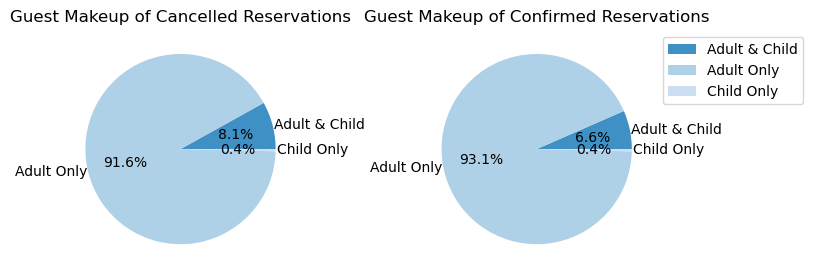

In [19]:
comp2_plot(cx, ncx,2)

- Fig 2.1 Pie plots showing the proportion of different guest composition in bookings recorded

The above pie plots show the guest composition of reservations recorded categorized into 3 groups: adults, children and adults and children. From the above pie charts, we observe that the guest breakdown in `Booking Canceled` is similar to that in `Booking Confirmed`. Therefore, there does not seem to be a strong relationship between the guest breakdown and cancellation status.

Moreover, the pie charts show that over 90% of their guest group are adults only. The second largest consumer group is the adults with children, but the proportion is drastically smaller compared to the first group of adults only. Additionally, some reservations are booked by children independently and this only counts for 0.4% .


### Number of Days Between the Date of Booking and the Arrival Date VS Booking Status

In [20]:
def leadt_plot(s1, s2, alp, loco, lolg):
    fig, ax = plt.subplots(figsize = (7,5))
    s1.plot(kind = 'hist', ax = ax, alpha = alp, color = loco[0], bins = range(0,510,30), rwidth=0.9)
    s2.plot(kind = 'hist', ax = ax, alpha = alp, color = loco[1], bins = range(0,510,30), rwidth=0.9)

    ax.set_title('Spread of the Number of Days Between the Date of Booking and the Arrival Date')
    ax.set_xlabel('Lead Time (Day)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.xticks(range(0,510,30))
    plt.legend(lolg, loc = 7)

    return ax

In [21]:
lead_cx = rsvn.loc[rsvn['booking_status'] == 'Canceled','lead_time']
lead_ncx = rsvn.loc[rsvn['booking_status'] == 'Not_Canceled','lead_time']

<AxesSubplot:title={'center':'Spread of the Number of Days Between the Date of Booking and the Arrival Date'}, xlabel='Lead Time (Day)', ylabel='Frequency'>

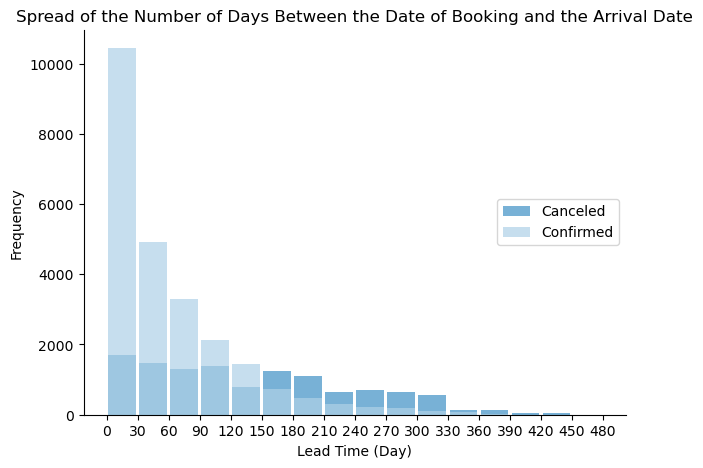

In [22]:
leadt_plot(lead_cx, lead_ncx, 0.7, colors, ['Canceled', 'Confirmed'])

- Fig 2.2 Distribution of lead time by booking status

Above, we explore the relationship between booking status and lead time, defined as number of days between the date of booking and  arrival date. The histogram shows that most bookings are recorded within 120 days from the check in date, while there are few people choose to make a reservation more than one year in advance. 

It is intuitive and notable from the graph above that higher proportion of bookings are confirmed rather than cancelled closer to check-in date. For instance, if the lead time is more than 5 months (150 days), the proportion of booking cancellation exceeds booking confirmation.

### Room Type

In [23]:
def rtype_pr_plot(df1, df2, loco):
    fig, ax = plt.subplots(figsize = (7,5))

    df1.plot(kind = 'bar', ax =ax, color = loco[0:2], xlabel = 'Room Type Reserved', ylabel = 'Counts')
    ax.legend(bbox_to_anchor=(-0.1, 0.48, 0.5, 0.5), labels = ['Canceled','Confirmed'])

    ax_ = ax.twinx()
    df2.plot(kind = 'line', ax = ax_, color = loco[0:2], ylabel = 'Average Preice per Room Reserved ($)')
    ax_.legend(bbox_to_anchor=(0.1, 0.48, 0.5, 0.5), labels = ['Canceled','Confirmed'])

    plt.xticks(np.arange(7), ['Type 1', 'Type 2', 'Type 3', 'Type 4', 'Type 5', 'Type 6', 'Type 7'])
    plt.suptitle('Room Type Reserved and Average Price per Night')

    for i in range(df1.shape[0]):
        ax.annotate(df1.values[i,0], (i-0.3, df1.values[i,0]+300))
        ax.annotate(df1.values[i,1], (i, df1.values[i,1]+300))

        ax_.annotate(int(df2.values[i,0]), (i, df2.values[i,0]+2), ha = 'center')
        ax_.annotate(int(df2.values[i,1]), (i, df2.values[i,1]+2), ha = 'center')

    return ax

In [24]:
rtype_count_status = rsvn[['room_type_reserved', 'booking_status']].groupby(['room_type_reserved', 'booking_status']).size()
rtype_count_status = rtype_count_status.unstack()
rtype_price_status = rsvn[['room_type_reserved', 'avg_price_per_room','booking_status']].groupby(['room_type_reserved', 'booking_status']).mean()
rtype_price_status = rtype_price_status.unstack()

<AxesSubplot:xlabel='Room Type Reserved', ylabel='Counts'>

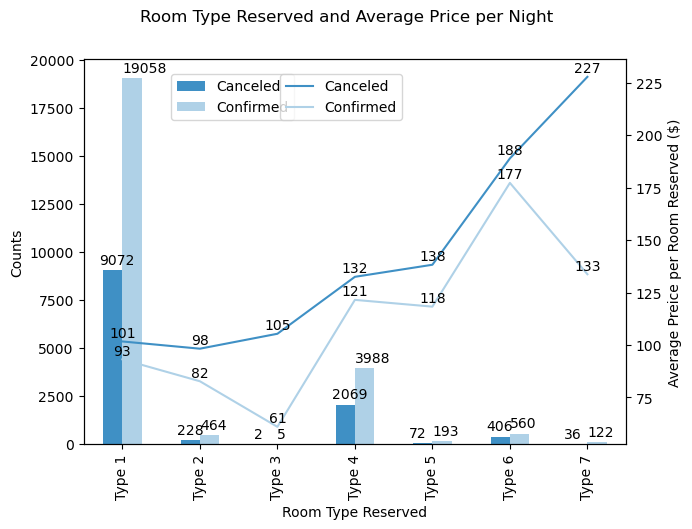

In [25]:
rtype_pr_plot(rtype_count_status,rtype_price_status, colors)

- Fig 2.3 Combined Line and Bar plots showing the prices of each room type and their popularites

From the bar chart, we can see Type 1 is the most booked room followed by Type 4. The line chart shows the average price per night of the different room types, and we see that Room Type 1 is cheaper in comparison to other rooms at the hotel and we observe increasing room prices as we go from Type 1 all the way to Type 7. 

For all room types, the cancellation rates range from approximately 22% to 42%, indicating that Room Types may have some effect on booking status. 

### Average Prices per Night vs Booking Status

In [26]:
def pr_plot(stat, df, loco):
    fig, ax = plt.subplots(1,len(stat), sharey=True, figsize = (4,4))
    for i in range(len(stat)):
        df.loc[df.index == stat[i],:].plot(kind = 'box', ax = ax[i])
        ax[i].spines[['left', 'right', 'top' ,'bottom']].set_visible(False)
        ax[i].tick_params(which="both", left=False, labelbottom=False)
        ax[i].set_xlabel(stat[i])
    fig.suptitle('Average Prices per Night vs Booking Status')
    ax[0].set_ylabel('Average Preice per Room Reserved ($)')
    fig.tight_layout()
    return ax

In [27]:
status = rsvn['booking_status'].unique()
rsvn_pr_bk = rsvn.loc[:, ['booking_status', 'avg_price_per_room']]
rsvn_pr_bk.set_index('booking_status', inplace=True)

array([<AxesSubplot:xlabel='Not_Canceled', ylabel='Average Preice per Room Reserved ($)'>,
       <AxesSubplot:xlabel='Canceled'>], dtype=object)

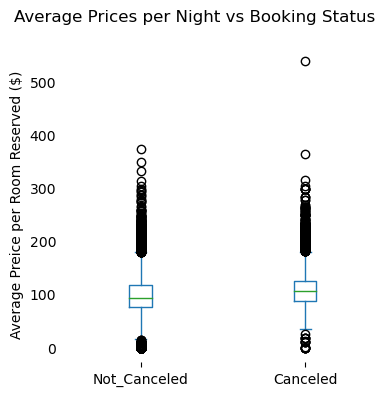

In [28]:
pr_plot(status, rsvn_pr_bk, colors)

- Fig 2.4 Boxplot showing the average price of room per night by booking status

The spread of price booked for canceled booking versus confirmed booking are comparable. We observe that the room pricse for canceled bookings are slightly higher than the room prices for confirmed bookings on average, with the mean price being around 100 dollars.

### Repeated guest vs cx_rsvn_pcg vs booking_status

In [29]:
rep_c = rsvn[['repeated_guest', 'booking_status']].groupby(['repeated_guest']).count()
repeat = rsvn.loc[rsvn['repeated_guest'] == 1,[ 'booking_status', 'cx_rsvn_pcg']]

In [30]:
def rep_cx_r(repeat_count, rep_sta_cxr):
    fig, ax = plt.subplots(1,2,figsize = (14,4))

    repeat_count.plot(kind = 'pie', y = 'booking_status', ax = ax[0], autopct = '%1.1f%%',colors = colors[0:2], ylabel = "", labels = ['New Guest', 'Repeated Guest'], title = "New vs Repeated Guests")
    ax[0].legend(labels = ['New Guest', 'Repeated Guest'], bbox_to_anchor=(0.8, 1))

    ax[0].annotate(
        "",
        xy=(2.8, 1), xycoords="data", xytext=(0.8, -0.08),
        annotation_clip=False,
        # horizontalalignment="right",
        arrowprops={
            "arrowstyle": "-|>",
            "color": "black"
        },
        fontsize=12,
    )

    rep_sta_cxr.plot(kind = 'box', by = 'booking_status', ax=ax[1], ylabel = "Histroical Cancellation Rate")
    ax[1].set_title('Cancellation Rate of Repeated guests')

    plt.suptitle('Proportion of New Guests and Booking Behaviour of Repeated Guest', x = 0.5, y =1.02)

    return ax

array([<AxesSubplot:title={'center':'New vs Repeated Guests'}>,
       <AxesSubplot:title={'center':'Cancellation Rate of Repeated guests'}, ylabel='Histroical Cancellation Rate'>],
      dtype=object)

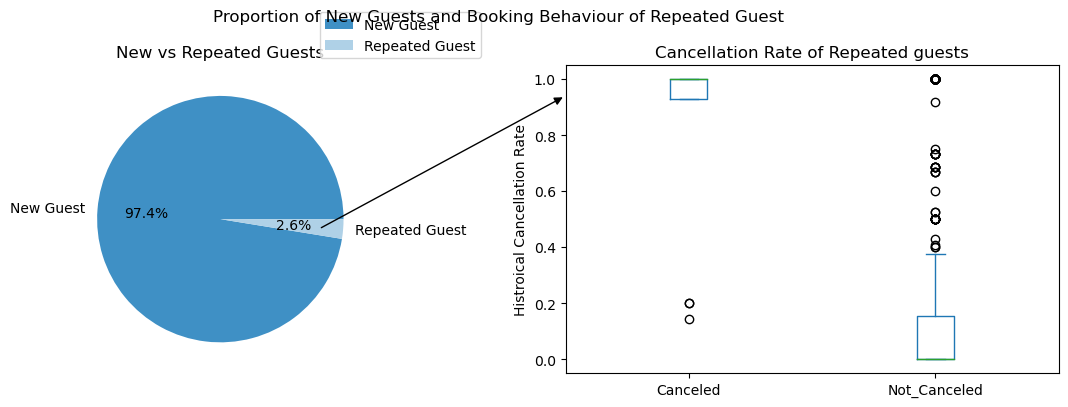

In [31]:
rep_cx_r(rep_c, repeat)

- Fig 2.5 Pie chart and boxplot showing whether the guest are repeated and the consumer behavior of repeated guests

The majority of customers are new guest and only 2.6% of the bookings are from repeated guests. Among the few repeated guests, the cancellation rate is extremely high, almost 1, for people who canceled the last booking whereas it's nearly zero for people who don't cancel the last booking with many outliers. This may because the records for individuals are limited so we can not get the consumer behavior independently.

### Market Segment vs booking status

In [32]:
seg_bk = rsvn[['market_segment_type', 'booking_status']]
classify_sta = seg_bk.groupby(['market_segment_type','booking_status'])['booking_status'].count().unstack()
classify_sta.loc[('Complementary','Canceled')] = 0 # Fix Nan
classify = seg_bk.groupby('market_segment_type').count()

In [33]:
def market_segment(segment_status, segment):
    fig, ax = plt. subplots(1,2, figsize = (14,6))

    segment_status.plot(kind = 'barh', ax = ax[0], color = colors[0:2], ylabel = "", xlabel = "Counts")
    ax[0].legend(loc = 8)
    ax[0].set_title('Counts for Market Segment by Booking Status')
    for i in range(segment_status.shape[0]):
        ax[0].annotate(segment_status.values[i,0], (segment_status.values[i,0]+100,i-0.2))
        ax[0].annotate(segment_status.values[i,1], (segment_status.values[i,1]+100, i+0.1))
    ax[0].annotate(
    "",
    xy=(35300, 2), xycoords="data", xytext=(10, 0),
    annotation_clip=False,
    horizontalalignment="left",
    arrowprops={
        "arrowstyle": "-|>",
        "connectionstyle": "angle3,angleA=0,angleB=150",
        "color": "black"
    },
    fontsize=12,
    )

    segment.plot(kind = 'pie', y = 'booking_status', ax = ax[1], colors = colors[4:10],  autopct = '%1.1f%%', subplots=True, ylabel = "")
    ax[1].legend(bbox_to_anchor=(1, 0.5, 0.5, 0.5))
    ax[1].set_title('Proportion of each Market Segment')


    plt.suptitle('Market Segment and Booking Status')
    return ax

array([<AxesSubplot:title={'center':'Counts for Market Segment by Booking Status'}, ylabel='Counts'>,
       <AxesSubplot:title={'center':'Proportion of each Market Segment'}>],
      dtype=object)

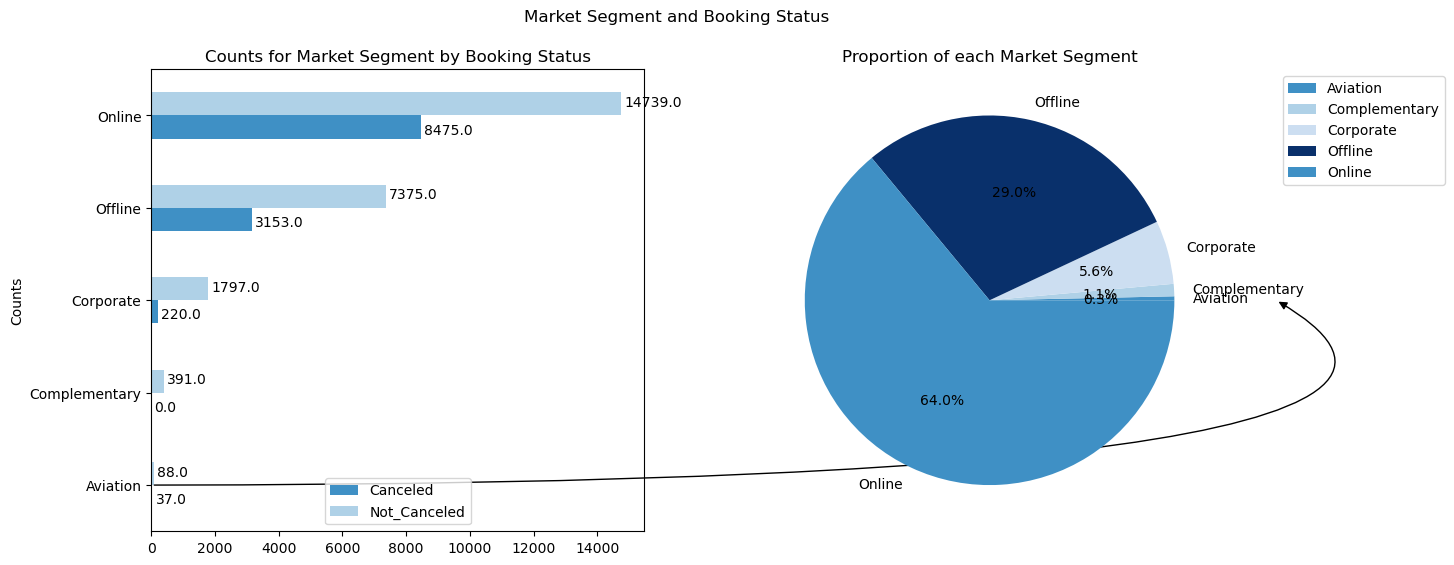

In [34]:
market_segment(classify_sta, classify)

- Fig 2.6 Bar chart and pie plot showing the market segment

The pie plot tells approximately 64% of the booking was done online and 29% was done offline. Besides such 2 common ways of reservation, there are still less than 10% booking was completed from corporate, complementary and aviation. It is notable that all the 391 records of booking from the complementary section are confirmed and it is the only section that doesn't contain any canceled record. Besides, in the corporate sector the number of booking confirmation is 8 times the cancellation, which is much higher than the average. In the rest 4 sections the number of confirmation is approximately twice than the reservation, which is consistent with the general cancellation pattern across sectors.

## Data Splitting & Correlation between variables

In [35]:
X = rsvn.drop(columns=["booking_status"]) 
y = rsvn.booking_status
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We plot the correlation between variables pairs below:

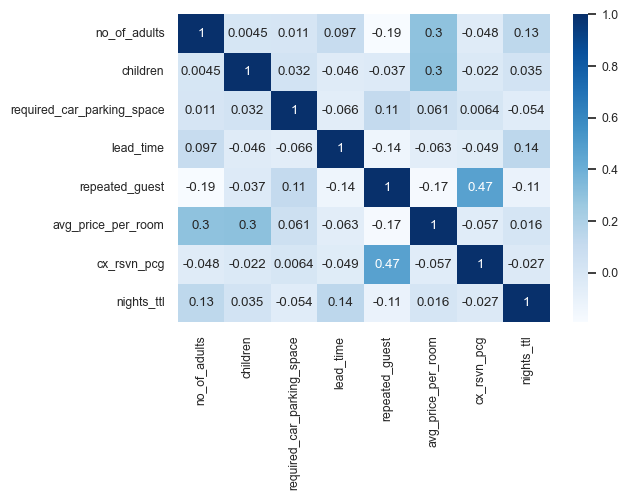

In [36]:
cor = X.corr()
plt.figure(figsize=(6, 4))
sns.set(font_scale=0.8)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

- Fig 2.7 Correlation between variables

Examining the correlation plot among the variables, there doesn't seem to be strong correlation among any two variables in our dataset. We note that there is some positive correlation between repeated guest status `repeated_guest` and % cancelled reservations `cx_rsvn_pcg`, as well as between average room price `avg_price_per_room` and both of number of adults in the reservations `no_of_adults` and whether there are children in the reservation `children`. 

# Preprocessing

Before training our models, we preprocess our data according to their data types to ensure that the numerical features have same scaled proportional effect on the model and that the categorical features processed appropriately. 

In [37]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)

ct = make_column_transformer(
    (numeric_transformer, numerical_columns),
    (categorical_transformer, categorical_columns),
    ("passthrough", binary_columns)
)

transformed_df = pd.DataFrame(ct.fit_transform(X_train))
new_labels = ['no_of_adults', 'lead_time', 'avg_price_per_room', 'cx_rsvn_pcg', 'nights_ttl', 'meal_plan_1', 'meal_plan_2',
              'meal_plan_3', 'meal_not_selected', 'room type 1', 'room type 2' , 'room type 3', 'room type 4',  'room type 5',
              'room type 6', 'room type 7', 'aviation', 'complementary', 'corporate', 'offline', 'online',
              'children', 'required_car_parking_space', 'repeated_guest']
transformed_df.columns = new_labels

In [38]:
transformed_df

,no_of_adults,lead_time,avg_price_per_room,cx_rsvn_pcg,nights_ttl,meal_plan_1,meal_plan_2,meal_plan_3,meal_not_selected,room type 1,...,room type 6,room type 7,aviation,complementary,corporate,offline,online,children,required_car_parking_space,repeated_guest
0,0.300222,-0.691565,1.636392,-0.076401,-0.005584,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.300222,0.147033,0.512227,-0.076401,-0.570254,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0.300222,4.048843,-0.953457,-0.076401,-0.005584,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.300222,1.276811,-0.889422,-0.076401,2.253093,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-1.627739,1.195281,0.754136,-0.076401,-0.570254,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29015,0.300222,-0.493562,-1.380355,-0.076401,0.559085,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
29016,-1.627739,0.193622,-0.668858,-0.076401,-0.570254,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
29017,0.300222,-0.936156,0.184938,-0.076401,-0.570254,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
29018,0.300222,1.486460,0.754136,-0.076401,-0.005584,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Model Selection
We test the four listed models below for accuracy, precision and recall scores to select the best performing model on our data set. 
1. Logistic regression
2. Random forest 
3. Decision tree
4. SVC

To evaluate our models, we especially pay attention to recall to prioritize minimizing false negatives, since inaccurately predicting that one will not cancel when they will would be more important to the hotel's business. 

In [39]:
y_train = y_train == "Canceled"
y_test = y_test == "Canceled"

results = {}

In [40]:
def scores(model, X_test, y_test):
    scores = []
    scores.append(np.round(accuracy_score(y_test, model.predict(X_test)),4))
    scores.append(np.round(recall_score(y_test, model.predict(X_test)),4))
    scores.append(np.round(f1_score(y_test, model.predict(X_test)),4))
    
    return pd.Series(data=scores, index=["accuracy", "recall", "f1"])

In [41]:
pipe_lr = make_pipeline(ct, LogisticRegression(solver='lbfgs', max_iter=1000))
pipe_lr.fit(X_train, y_train)
results["logistic regression"] = scores(pipe_lr, X_test, y_test)

pipe_rf = make_pipeline(ct, RandomForestClassifier())
pipe_rf.fit(X_train, y_train)
results["random forest"] = scores(pipe_rf, X_test, y_test)

pipe_dt = make_pipeline(ct, DecisionTreeClassifier(max_depth=5))
pipe_dt.fit(X_train, y_train)
results["decision tree"] = scores(pipe_dt, X_test, y_test)

pipe_svc = make_pipeline(ct, SVC())
pipe_svc.fit(X_train, y_train)
results["SVC"] = scores(pipe_svc, X_test, y_test)


pd.DataFrame(results).T

,accuracy,recall,f1
logistic regression,0.7626,0.4793,0.5736
random forest,0.8345,0.6995,0.7378
decision tree,0.7819,0.4102,0.5561
SVC,0.7891,0.4565,0.5905


The results above indicate that random forest gives highest accuracy overall as well as highest recall and f1 scores. We will therefore use the random forest model in the next step of variable selection.

# Variable Selection

In this section, we use the eli5 package to visualize and select the most important features to avoid fitting the model on every feature provided which risks overfitting on the training set. 

In [42]:
eli5.explain_weights(
    pipe_rf.named_steps["randomforestclassifier"], feature_names=new_labels, top=24
)

Weight,Feature
0.5138 ± 0.0424,lead_time
0.3073 ± 0.0371,avg_price_per_room
0.0826 ± 0.0272,nights_ttl
0.0234 ± 0.0144,no_of_adults
0.0128 ± 0.0136,online
0.0086 ± 0.0023,required_car_parking_space
0.0080 ± 0.0115,offline
0.0055 ± 0.0060,meal_plan_2
0.0054 ± 0.0035,children
0.0050 ± 0.0050,meal_plan_1


eli5.explain_weights(
    pipe_rf.named_steps["randomforestclassifier"], feature_names=new_labels, top=30
)

According to the results above, the top three most significant feature are `lead_time`, `avg_price_per_room` and `nights_ttl`. 

### Force Plots

In [43]:
shap.initjs()

In [44]:
explainer = shap.TreeExplainer(pipe_rf.named_steps["randomforestclassifier"])

In [45]:
X_train_tf = ct.transform(X_test)

In [46]:
X_enc_df = pd.DataFrame(X_train_tf, columns=new_labels)

In [ ]:
shap_values = explainer.shap_values(X_enc_df)

In [ ]:
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][300, :],
    X_enc_df.iloc[300, :],
    matplotlib=True,
)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_enc_df.iloc[0,:])

# 5. Discussion

## 5.1 Results and Conclusion

Using the random forest classifier model, we found that `lead_time`, `avg_price_per_room` and `nights_ttl` are the top three factors affecting hotel booking status. 

TODO- Sol


## 5.2 Limitation

TODO- Sol

## 5.3 Future Study

TODO - Jinghan

# 6. Reference
- [Kaggle](https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset)